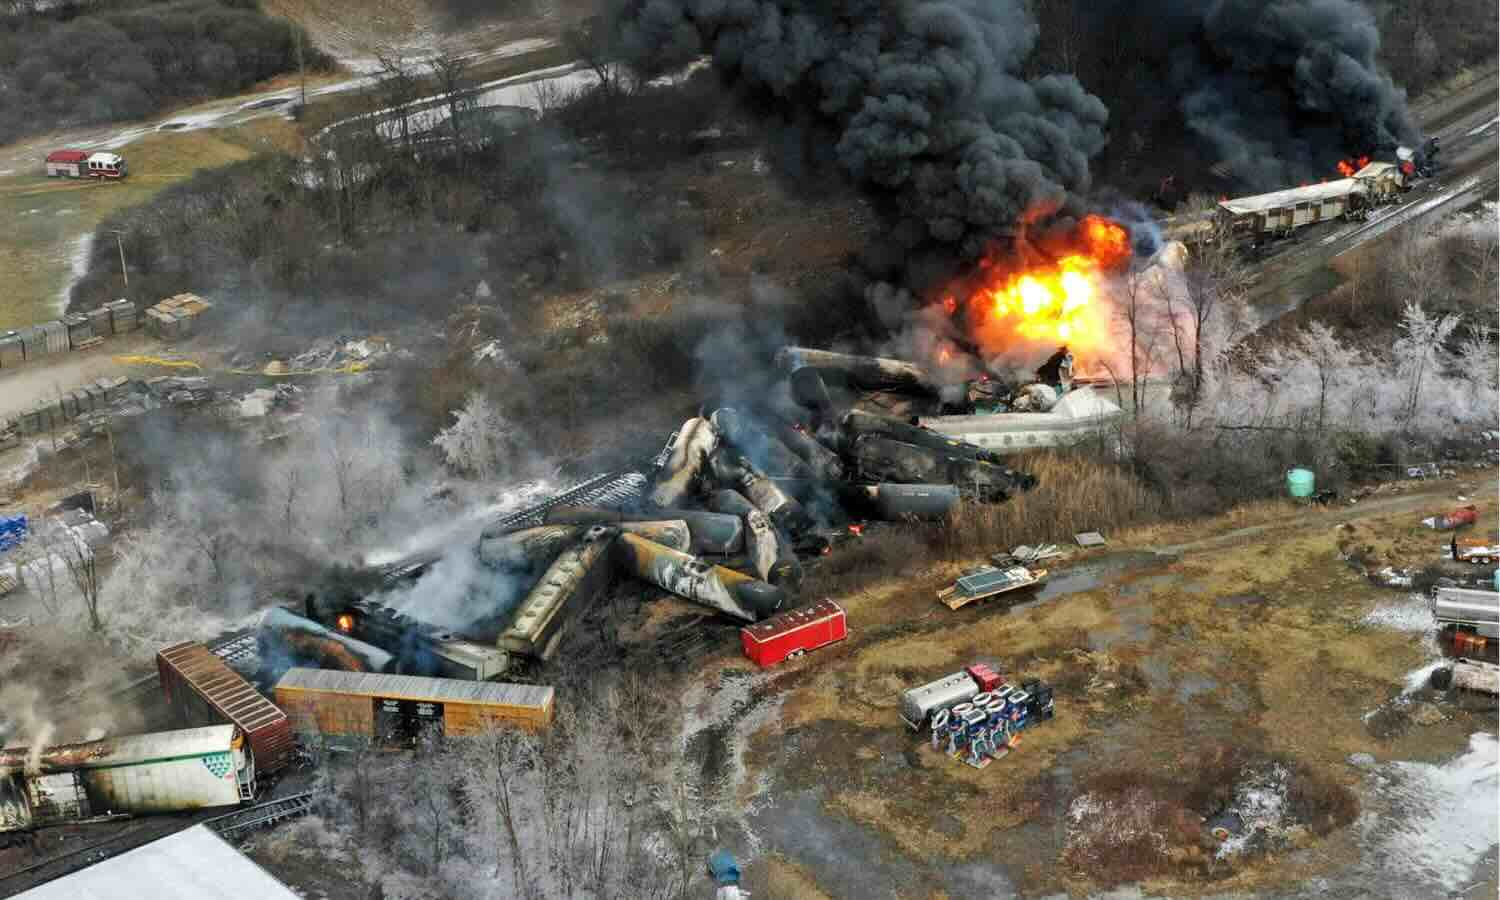

---

### SUMMARY

1. Read the Data
2. Exploratory Data Analysis
3. Data Preprocessing
4. Building the Classifier Model

---

# 1. Read the Data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report,confusion_matrix

import datasets
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer,AutoModel,TrainingArguments
from transformers import AutoModelForSequenceClassification,AutoConfig
from transformers import Trainer,BertModel,BertForSequenceClassification
from transformers import DataCollatorWithPadding
import torch

from warnings import simplefilter
simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [3]:
!pip install wandb

import wandb

In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("WANDB") 
wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
!pip install evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


In [6]:
!pip install peft

from peft import PeftModel,PeftConfig,get_peft_model,LoraConfig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 5.9 MB/s eta 0:00:00


In [7]:
# Read the train and test data and display the dataset
data_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
data_test  = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Rename the target column
data_train.rename(columns={'target':'labels'},inplace=True)

data_train.head() 

,id,keyword,location,text,labels
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Dimension of the train and test datasets
data_train.shape, data_test.shape

((7613, 5), (3263, 4))

**Null and duplicate values**

In [9]:
# Null values in train data
data_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
labels         0
dtype: int64

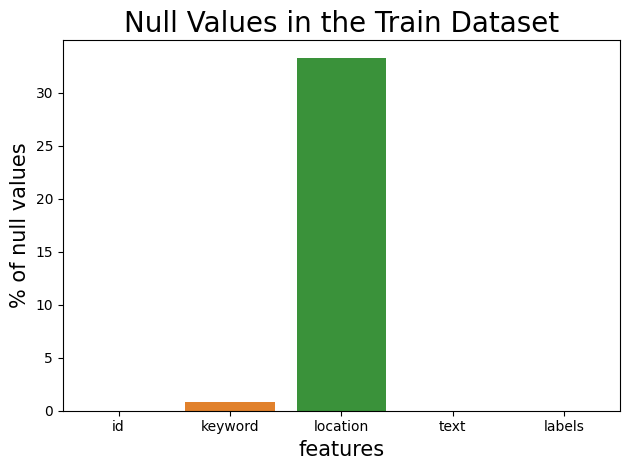

In [10]:
def plot_nulls(data,title,x_axis_label,y_axis_label):
    
    # number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')
    sns.barplot(data_nulls,x="index",y="count")
    
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=15)
    plt.ylabel(y_axis_label,fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
plot_nulls(data_train,"Null Values in the Train Dataset",'features','% of null values')  

In [11]:
# Null values in test data
data_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

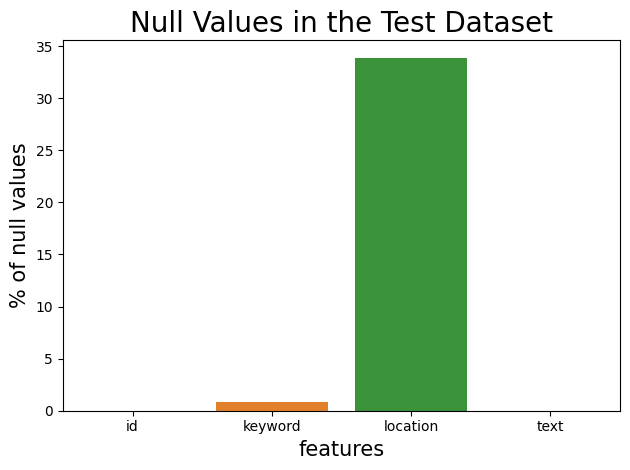

In [12]:
plot_nulls(data_test,"Null Values in the Test Dataset",'features','% of null values')  

In [13]:
# Duplicate values in train and test data
data_train.duplicated().sum(), data_test.duplicated().sum()

(0, 0)

**Shuffle the train data**

In [14]:
# Shuffle training dataframe
data_train = data_train.sample(frac=1,random_state=42) 

data_train.head()

,id,keyword,location,text,labels
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


# 2. Exploratory Data Analysis

## 2.1 Class balance/imbalance

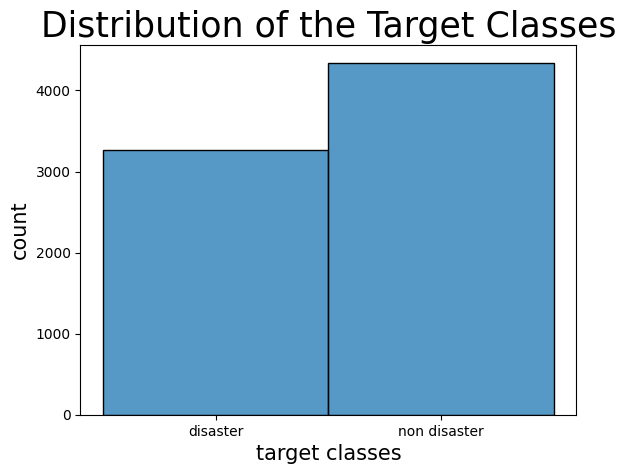

In [15]:
disaster_rate = {1:'disaster',0:'non disaster'}
data_train['label_names'] = data_train['labels'].map(disaster_rate)

sns.histplot(data=data_train.label_names)

plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15);

There is a slight class imbalance in the train dataset. It should be a problem.

## 2.2 Keyword

Let's print the number of unique keyword values.

In [16]:
print(f'No. of unique keyword values: {data_train.keyword.nunique()}')

print(f'Total No. of keywords: {data_train[~data_train.keyword.isnull()].keyword.count()}')

print(f'Ratio = {data_train.keyword.nunique()/data_train[~data_train.keyword.isnull()].keyword.count():.2f}')

No. of unique keyword values: 221
Total No. of keywords: 7552
Ratio = 0.03


In [17]:
print(f'No. of unique keyword values: {data_test.keyword.nunique()}')

print(f'Total No. of keywords: {data_test[~data_test.keyword.isnull()].keyword.count()}')

print(f'Ratio = {data_test.keyword.nunique()/data_test[~data_test.keyword.isnull()].keyword.count():.2f}')

No. of unique keyword values: 221
Total No. of keywords: 3237
Ratio = 0.07


The relative number of unique keywords is higher in the test data by a factor larger than 2.

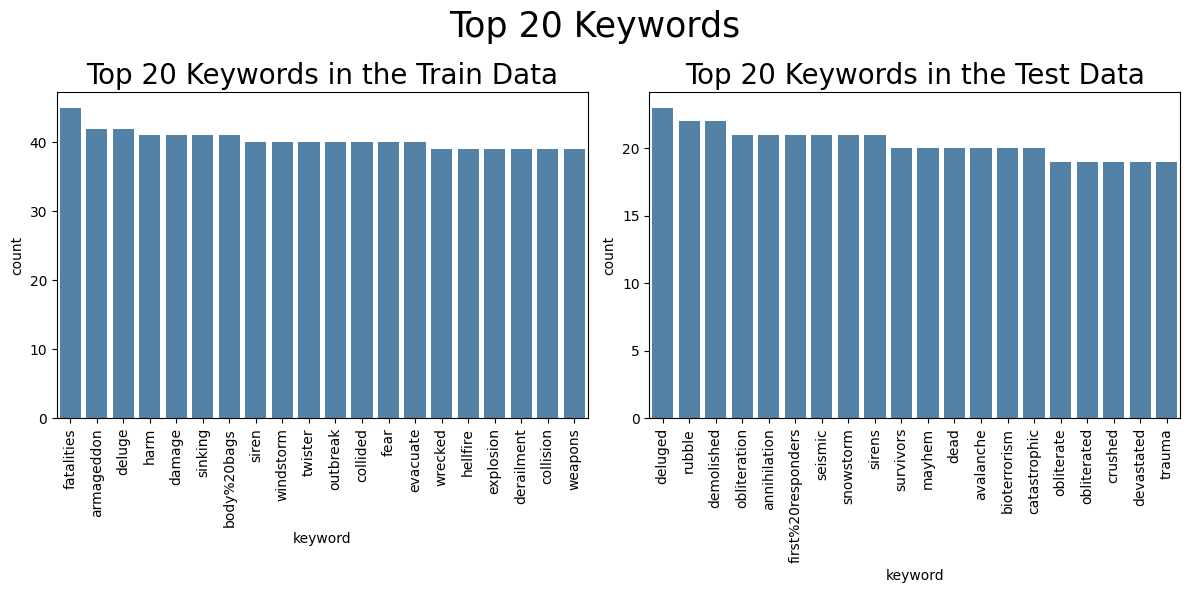

In [18]:
####################################
top20_keywords_train = data_train.groupby('keyword')['keyword'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)

top20_keywords_test = data_test.groupby('keyword')['keyword'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)
####################################

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.barplot(data=top20_keywords_train,x='keyword',y='count',color='steelblue',ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title('Top 20 Keywords in the Train Data',fontsize=20)

ax2 = sns.barplot(data=top20_keywords_test,x='keyword',y='count',color='steelblue',ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title('Top 20 Keywords in the Test Data',fontsize=20)

plt.suptitle('Top 20 Keywords',fontsize=25)

plt.tight_layout()

The top keywords in the train and test datasets are rather different. This means that the events in the two datasets may not be so similar.

## 2.3 Location

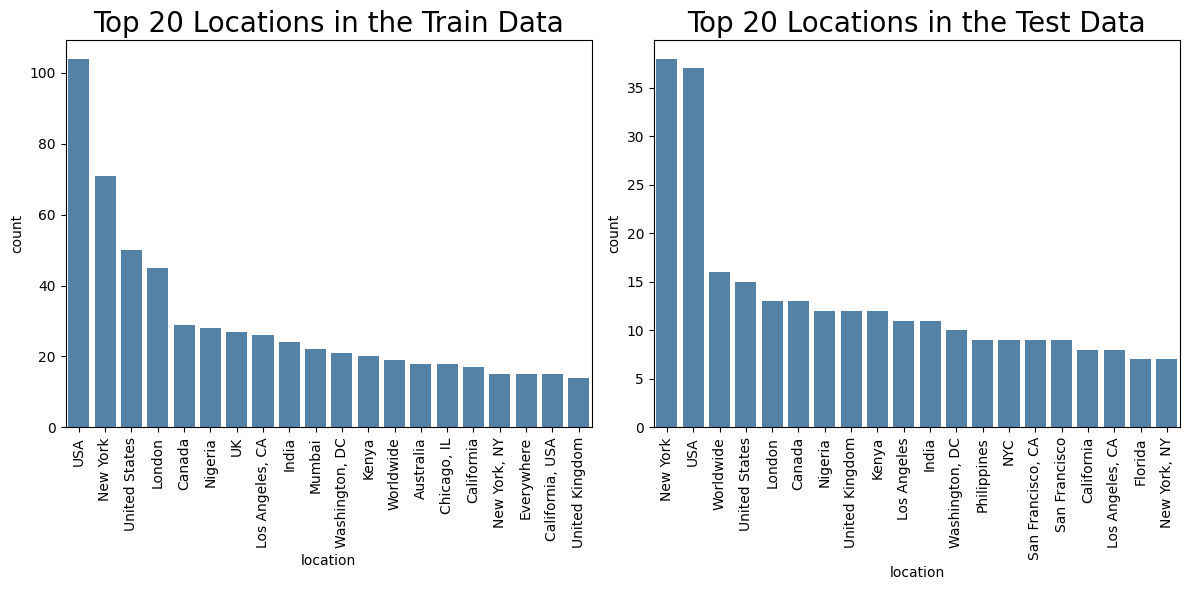

In [19]:
########################
top20_locations_train = data_train.groupby('location')['location'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)

top20_locations_test = data_test.groupby('location')['location'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)
########################

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.barplot(data=top20_locations_train,x='location',y='count',color='steelblue',ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title('Top 20 Locations in the Train Data',fontsize=20)

ax2 = sns.barplot(data=top20_locations_test,x='location',y='count',color='steelblue',ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title('Top 20 Locations in the Test Data',fontsize=20)

plt.tight_layout()

The most occurring locations are in the USA.

## 2.4 Text

### 2.4.1 First Observations

First, let's find the number of different messages in the train dataset.

In [20]:
data_train['text'].nunique(), len(data_train)

(7503, 7613)

They are 7503 out of 7613. The majority of them are unique.

Next, we are checking if the disaster and non-disaster tweets differ by the length, most frequent words ...

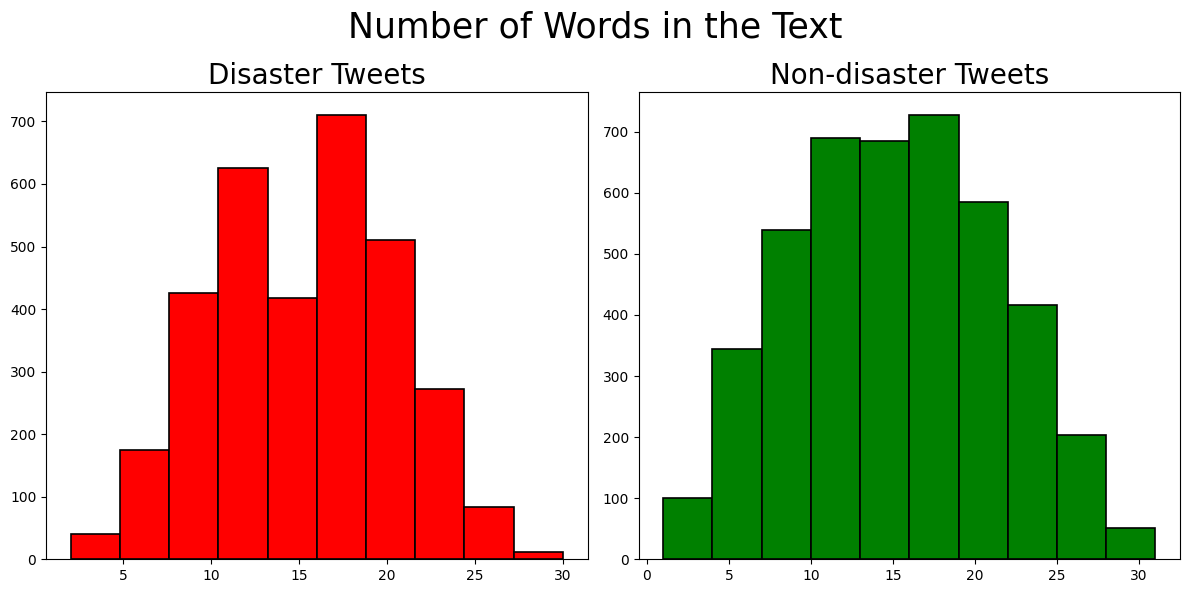

In [21]:
#######################
num_words_dis = data_train[data_train['labels']==1]['text'].str.split().map(lambda x: len(x))

num_words_ndis = data_train[data_train['labels']==0]['text'].str.split().map(lambda x: len(x))
#######################

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(num_words_dis,color='red',edgecolor='black',linewidth=1.2)
ax1.set_title('Disaster Tweets',size=20)

ax2.hist(num_words_ndis,color='green',edgecolor='black',linewidth=1.2)
ax2.set_title('Non-disaster Tweets',size=20)

plt.suptitle("Number of Words in the Text",size=25)
plt.tight_layout()
plt.show()

These are the means and standard deviations of the above distibutions.

In [22]:
print(f'\n mean no. of words disaster tweets: {num_words_dis.mean():.1f} \n mean no. of words non disaster tweets: {num_words_ndis.mean():.1f}')

print(f'\n std dev disaster tweets: {num_words_dis.std():.1f} \n std dev non disaster tweets: {num_words_ndis.std():.1f}')


 mean no. of words disaster tweets: 15.2 
 mean no. of words non disaster tweets: 14.7

 std dev disaster tweets: 5.1 
 std dev non disaster tweets: 6.2


The two distibutions are quite similar.

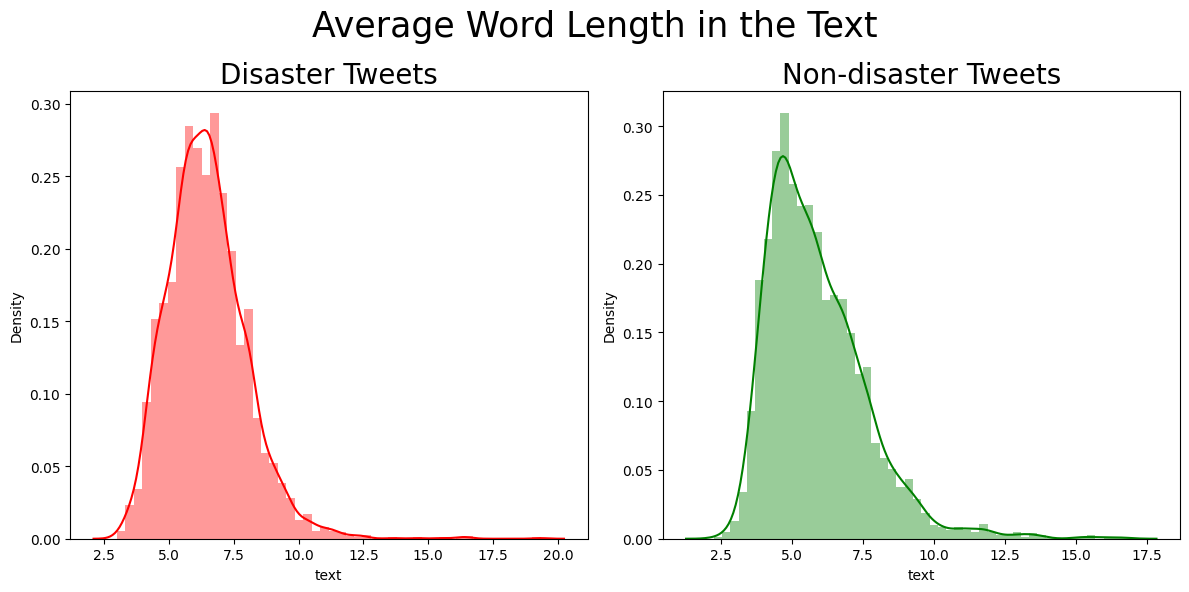

In [23]:
########################
char_len_dis = data_train[data_train['labels']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])

char_len_ndis = data_train[data_train['labels']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
########################

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

sns.distplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Disaster Tweets',size=20)

sns.distplot(char_len_ndis.map(lambda x:np.mean(x)),ax=ax2,color='green')
ax2.set_title('Non-disaster Tweets',size=20)

plt.suptitle("Average Word Length in the Text",size=25)
plt.tight_layout()
plt.show()

### 2.4.2 Most Common Words

I am defining a function to clean the text.

In [24]:
data_train2 = data_train.copy()
data_test2  = data_test.copy()


def clean_text(data_in,col):

    data = data_in.copy()

    # Remove dots, commas, numbers ... from the text
    for i in range(len(data_in)):
        data[col].iloc[i] = re.sub(r'[0-9].',' ',data[col].iloc[i]).lower().replace('?','').replace('_','').replace('û','').replace('ï','').replace('&','').replace(':','').replace(',','').replace('.','').replace('!','').replace('-','').replace('(','').replace("'",'').replace('#','').replace(';','').replace(')','').lstrip().rstrip()

    # Stopwods from nltk
    stop = stopwords.words('english')
    # Remove stopwords
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # Remove http's
    data[col] = data[col].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

    # Remove hashtags
    data[col] = data[col].str.replace(r'\s*@\w+', '', regex=True)
    data[col] = data[col].str.replace(r'\s*\B@\w+', '', regex=True)
    data[col] = data[col].str.replace(r'\s*@\S+', '', regex=True)
    data[col] = data[col].str.replace(r'\s*@\S+\b', '', regex=True)

    # Remove words shorter than 2 characters
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))

    return data
    

data_train2 = clean_text(data_train2,'text')
data_test2  = clean_text(data_test2,'text')
data_train2.head()    

,id,keyword,location,text,labels,label_names
2644,3796,destruction,NaN,new weapon cause unimaginable destruction,1,disaster
2227,3185,deluge,NaN,f$amp things gishwhes got soaked deluge going ...,0,non disaster
5448,7769,police,UK,ayor the col police catch pickpocket liverpoo...,1,disaster
132,191,aftershock,NaN,aftershock back school kick great want thank e...,0,non disaster
6845,9810,trauma,"Montgomery County, MD",response trauma children addicts develop defen...,0,non disaster


**Most common words in tweets**

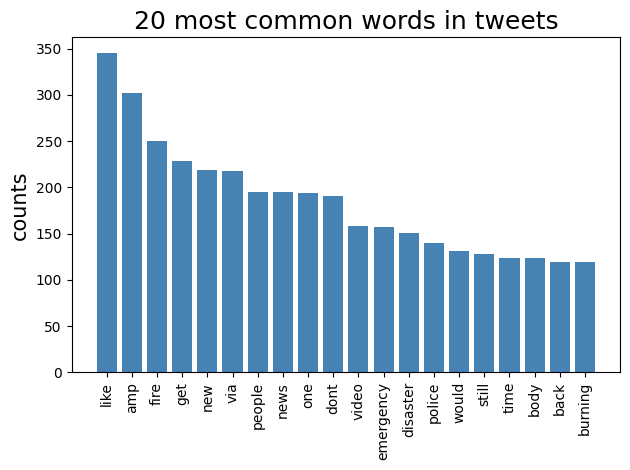

In [25]:
num_words = Counter(" ".join(data_train2["text"]).split()).most_common(20)

x,y = zip(*num_words)

plt.bar(x,y,color='steelblue')
plt.xticks(rotation=90)
plt.title("20 most common words in tweets",size=18)
plt.ylabel("counts",size=15)

plt.tight_layout()
plt.show()

**Most common words in disaster and non disaster tweets**

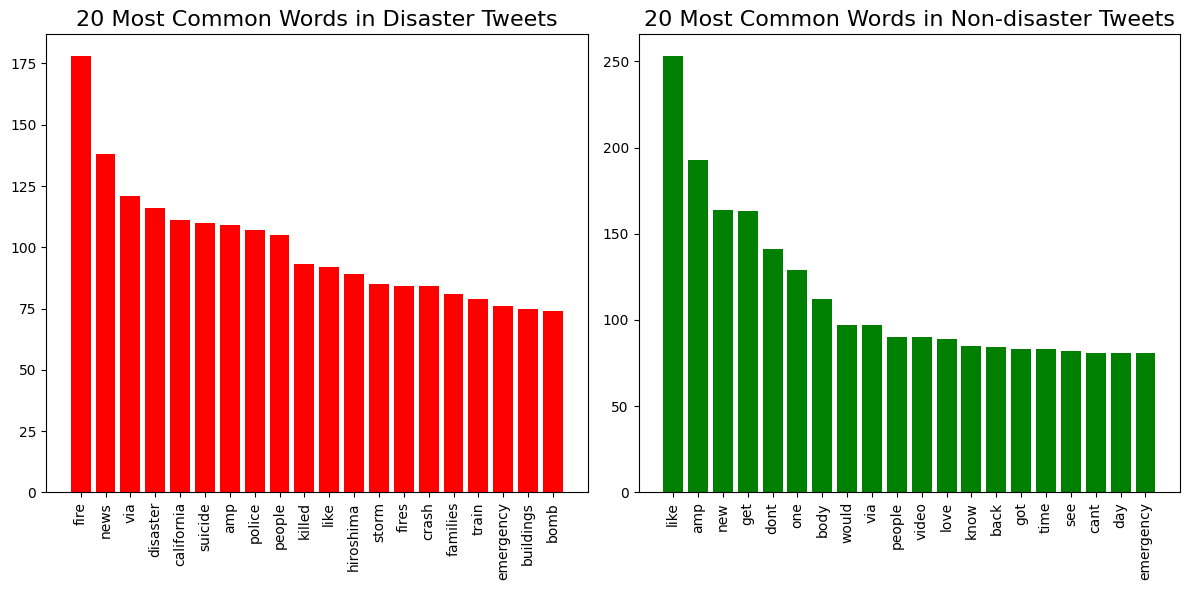

In [26]:
data_disaster = data_train2[data_train2['labels'] == 1]
data_nondisaster = data_train2[data_train2['labels'] == 0]

num_words_disaster = Counter(" ".join(data_disaster["text"]).split()).most_common(20)
num_words_nondisaster = Counter(" ".join(data_nondisaster["text"]).split()).most_common(20)

x1,y1 = zip(*num_words_disaster)
x2,y2 = zip(*num_words_nondisaster)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.bar(x1,y1,color='red')
ax1.tick_params(axis='x',rotation=90)
ax1.title.set_text("20 Most Common Words in Disaster Tweets")
ax1.title.set_size(16)

ax2.bar(x2,y2,color='green')
ax2.tick_params(axis='x',rotation=90)
ax2.title.set_text("20 Most Common Words in Non-disaster Tweets")
ax2.title.set_size(16)

plt.tight_layout()
plt.show()

As shown in the above plots, some top words (like via) are shared in the two categories. There are also non relevant words, like cant and dont. I will remove them.

In [27]:
common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest','youre',
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp',
                'cant','dont','going','really','new','full','good','best','much','last','many','need','even','right','hot','never',
                'every','could','please','also','ive','says','hes']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data_train2["text"] = data_train2["text"].apply(text_cleaning)
data_test2["text"]  = data_test2["text"].apply(text_cleaning)

Now I am making the same plot with the updated set of words.

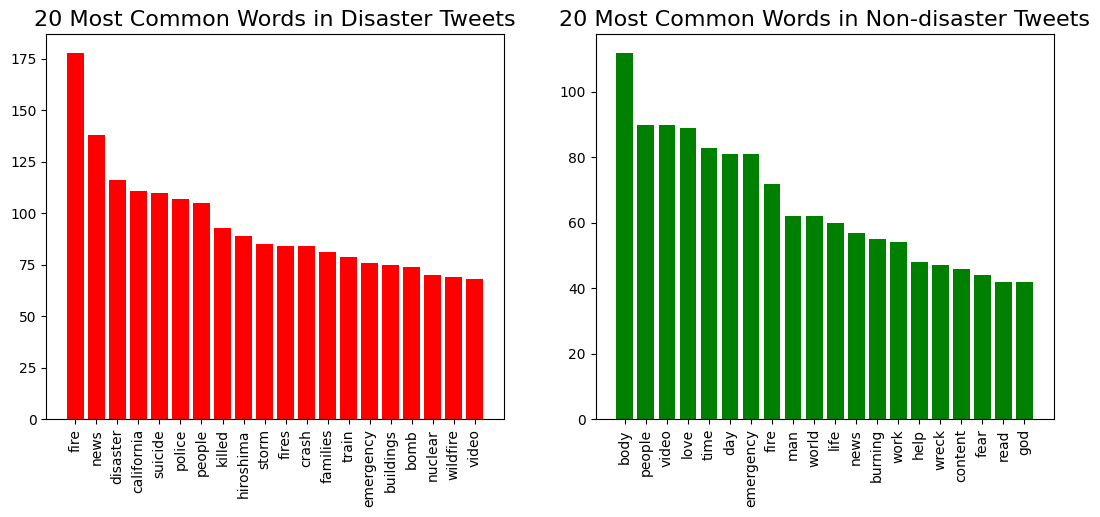

In [28]:
data_disaster = data_train2[data_train2['labels'] == 1]
data_nondisaster = data_train2[data_train2['labels'] == 0]

num_words_disaster = Counter(" ".join(data_disaster["text"]).split()).most_common(20)
num_words_nondisaster = Counter(" ".join(data_nondisaster["text"]).split()).most_common(20)

x1,y1 = zip(*num_words_disaster)
x2,y2 = zip(*num_words_nondisaster)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,5))

ax1.bar(x1,y1,color='red')
ax2.bar(x2,y2,color='green')
ax1.tick_params(axis='x',rotation=90)
ax2.tick_params(axis='x',rotation=90)
ax1.title.set_text("20 Most Common Words in Disaster Tweets")
ax2.title.set_text("20 Most Common Words in Non-disaster Tweets")
ax1.title.set_size(16)
ax2.title.set_size(16)
plt.show()

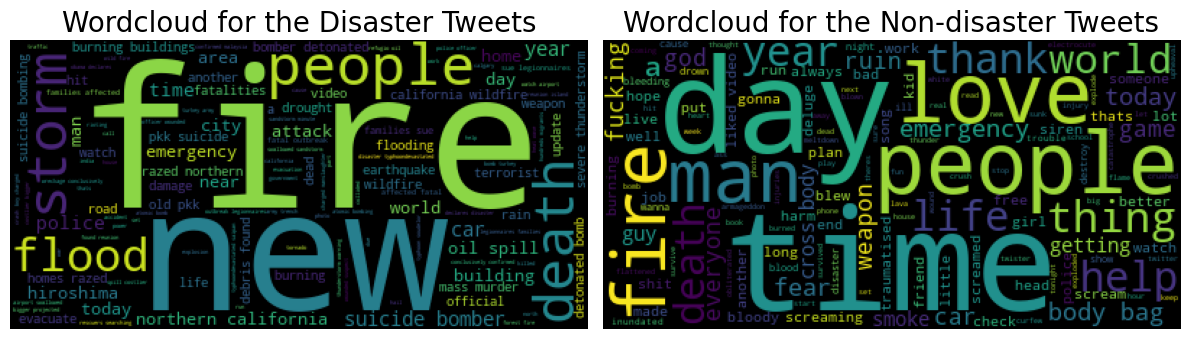

In [29]:
text_dis  = ' '.join(data_disaster['text'])
text_ndis = ' '.join(data_nondisaster['text'])

wordcloud_dis  = WordCloud().generate(text_dis)
wordcloud_ndis = WordCloud().generate(text_ndis)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_dis)
ax1.axis("off")
ax1.set_title('Wordcloud for the Disaster Tweets',fontsize=20)

ax2.imshow(wordcloud_ndis)
ax2.axis("off")
ax2.set_title('Wordcloud for the Non-disaster Tweets',fontsize=20)

plt.tight_layout()
plt.show()

Now I am plotting the curve showing the occurrence of the top 500 words to see what it looks like. I am expecting some kind of '1/x behavior' (feature occurrences should get smaller and smaller).

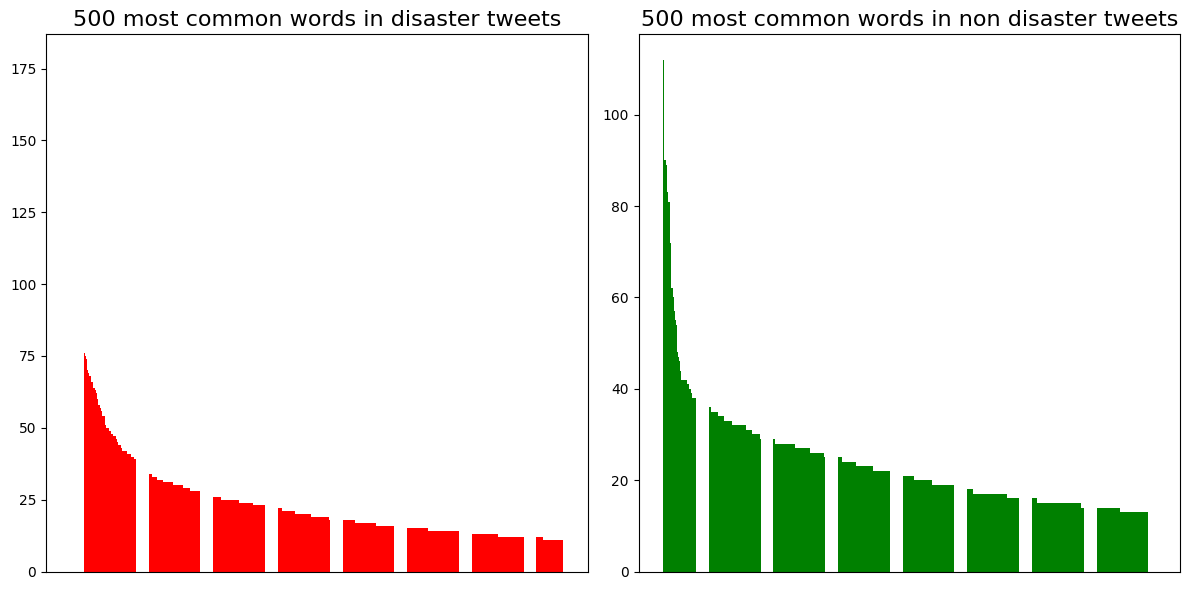

In [30]:
num_words_disaster2 = Counter(" ".join(data_disaster["text"]).split()).most_common(500)
num_words_nondisaster2 = Counter(" ".join(data_nondisaster["text"]).split()).most_common(500)

x1,y1 = zip(*num_words_disaster2)
x2,y2 = zip(*num_words_nondisaster2)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.bar(x1,y1,color='red')
ax1.title.set_text("500 most common words in disaster tweets")
ax1.title.set_size(16)
ax1.tick_params(labelbottom=False,bottom=False) 

ax2.bar(x2,y2,color='green')
ax2.title.set_text("500 most common words in non disaster tweets")
ax2.title.set_size(16)
ax2.tick_params(labelbottom=False,bottom=False) 

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

## 3.1 Text Cleaning

I am defining a second function for text cleaning. Then I will compare it with the previous one and see what does the best job.

In [31]:
data_train3 = data_train.copy()
data_test3  = data_test.copy()

nlp = spacy.load("en_core_web_sm")


def clean_text(text):

    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    doc = nlp(text)

    cleaned_tokens = []
    for token in doc:
        if token.text not in STOP_WORDS and not token.is_punct and not token.is_space:
            cleaned_tokens.append(token.lemma_)

    cleaned_tokens = ' '.join(cleaned_tokens)
    
    return cleaned_tokens
    
    
data_train3['text'] = data_train3['text'].apply(clean_text)
data_test3['text']  = data_test3['text'].apply(clean_text)

I am also removing emojis.

In [32]:
def remove_emoji(text):
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

data_train3['text'] = data_train3['text'].apply(lambda x: remove_emoji(x))
data_test3['text']  = data_test3['text'].apply(lambda x: remove_emoji(x))

I am dropping some (unnecessary) columns and then saving the id column for the final submission.

In [33]:
# Save test PassengerId in out_id
#train_id = data_train3["id"]
#test_id  = data_test3["id"]
train_id = data_train2["id"]
test_id  = data_test2["id"]

#data_train3.drop(['keyword','location','id'],axis=1,inplace=True)
#data_test3.drop(['keyword','location','id'],axis=1,inplace=True)
data_train2.drop(['keyword','location','id'],axis=1,inplace=True)
data_test2.drop(['keyword','location','id'],axis=1,inplace=True)

#data_train3.head()
data_train2.head()

,text,labels,label_names
2644,weapon cause unimaginable destruction,1,disaster
2227,f$amp things gishwhes soaked deluge pads tampo...,0,non disaster
5448,ayor the col police catch pickpocket liverpoo...,1,disaster
132,aftershock school kick thank everyone making p...,0,non disaster
6845,response trauma children addicts develop defen...,0,non disaster


## 3.2 Tokenization

I am performing train-validation splitting.

In [34]:
# Model checkpoint: uncased (it does not matter whether a word is lower or upper case)
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [35]:
# Check vocabulary size
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

In [36]:
# Train-test-validation split
#train,test      = train_test_split(data_train3,test_size=0.3,stratify=data_train3['labels'])
train,test      = train_test_split(data_train2,test_size=0.3,stratify=data_train2['labels'])
test,validation = train_test_split(test,test_size=1/3,stratify=test['labels'])

train.shape, test.shape, validation.shape

((5329, 3), (1522, 3), (762, 3))

In [37]:
# Convert dataframes to dictionaries
dataset = DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False),
     'validation':Dataset.from_pandas(validation,preserve_index=False),
     'final':Dataset.from_pandas(data_test2,preserve_index=False)
     }    
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 5329
    })
    test: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 1522
    })
    validation: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 762
    })
    final: Dataset({
        features: ['text'],
        num_rows: 3263
    })
})

In [38]:
# Have a look at two entries
dataset['train'][0], dataset['train'][1], dataset['train'][2]

({'text': 'brings alabama thunder attic september tickets wevsrgo',
  'labels': 0,
  'label_names': 'non disaster'},
 {'text': 'lightning strike distance /r/pics pics',
  'labels': 1,
  'label_names': 'disaster'},
 {'text': 'things fear organizationsfluctuations disturbances imbalancesare primary sources creativity margaret wheatley',
  'labels': 0,
  'label_names': 'non disaster'})

In [39]:
def tokenize(batch):
    temp = tokenizer(batch['text'],padding=True,truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 7545, 6041, 8505, 14832, 2244, 9735, 2057, 15088, 18581, 102, 0], [101, 7407, 4894, 3292, 1013, 1054, 1013, 27263, 2015, 27263, 2015, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [40]:
# batch_size = None ==> all data passed without any batch size
disaster_encoded = dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/5329 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/762 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [41]:
# label2id, id2label: mapping between labels (0, 1, 2 ...) and label names (love, fear, surprise ...)
label2id = {x['label_names']:x['labels'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'non disaster': 0, 'disaster': 1}, {0: 'non disaster', 1: 'disaster'})

# 4. Training the Classifier Model 

**Fine-Tuning Transformers**

I am using PEFT (Parameter-Efficient Fine-Tuning). This is a technique used in machine learning for the fine-tuning of large pre-trained models like transformers (e.g., BERT, GPT, etc.). In order to improve the results, I have to find the best values of the model parameters. The easiest way to obtain them is by running the model a few times with different values of such parameters.

In [42]:
num_labels = len(label2id)

# Where to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)

# to(device) ==> the model will be trained on cuda (GPU)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

peft_config = LoraConfig(
    task_type = "SEQ_CLS",
    # Rank: original matrix decomposed into 'r' rows and columns
    r = 16,
    # lora_alpha: scaling factor
    lora_alpha = 64, 
    # dropout parameter
    lora_dropout = 0.1, 
    target_modules = ["query"]
)    

model = get_peft_model(model,peft_config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
batch_size = 16
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 5, 
                                  learning_rate = 1e-4, 
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01, 
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False
)

HuggingFace does not have compute metrics by default. One has to build them.

In [44]:
# Build compute metrics function
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels,preds,average="weighted")
    acc = accuracy_score(labels,preds)

    return {"accuracy": acc, "f1": f1}

**Build Model and Trainer**

In [45]:
# Use data_collector to convert the samples to PyTorch tensors and concatenate them with the correct amount of padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=disaster_encoded['train'],
                  eval_dataset=disaster_encoded['validation'],
                  tokenizer=tokenizer,
                  data_collator=data_collator)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: jferretti1980 (jferretti1980-none). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241201_154620-9v3xr0ua
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bert_base_train_dir
wandb: ⭐️ View project at https://wandb.ai/jferretti1980-none/huggingface
wandb: 🚀 View run at https://wandb.ai/jferretti1980-none/huggingface/runs/9v3xr0ua


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.503402,0.767717,0.763178
2,No log,0.466362,0.796588,0.794220
3,0.530100,0.455767,0.804462,0.802323
4,0.530100,0.475206,0.796588,0.796118
5,0.530100,0.463345,0.797900,0.796531


TrainOutput(global_step=835, training_loss=0.49744518531296783, metrics={'train_runtime': 150.0801, 'train_samples_per_second': 177.539, 'train_steps_per_second': 5.564, 'total_flos': 508378520170200.0, 'train_loss': 0.49744518531296783, 'epoch': 5.0})

Now, it is time to evaluate the model on the test data.

In [46]:
preds_output = trainer.predict(disaster_encoded['test'])

preds_output.metrics

{'test_loss': 0.46826285123825073,
 'test_accuracy': 0.7969776609724047,
 'test_f1': 0.7949393441717771,
 'test_runtime': 3.5207,
 'test_samples_per_second': 432.297,
 'test_steps_per_second': 13.634}

In [47]:
y_pred = np.argmax(preds_output.predictions,axis=1)

y_true = disaster_encoded['test'][:]['labels']

In [48]:
print(classification_report(y_true,y_pred,target_names=list(label2id)))

              precision    recall  f1-score   support

non disaster       0.80      0.87      0.83       868
    disaster       0.80      0.70      0.75       654

    accuracy                           0.80      1522
   macro avg       0.80      0.79      0.79      1522
weighted avg       0.80      0.80      0.79      1522



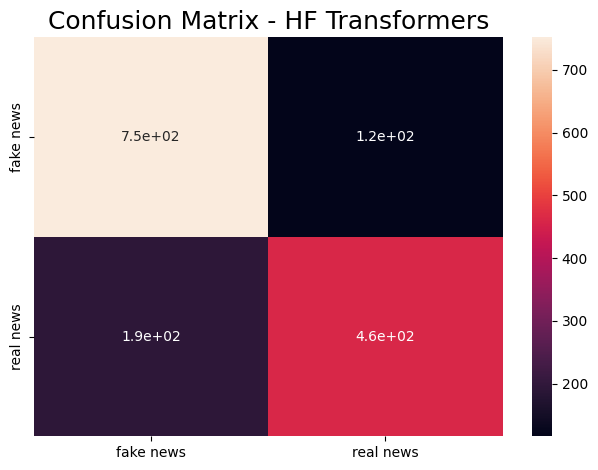

In [49]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_true,y_pred)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['fake news','real news']) 
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

# 5. Submitting the Results

In [50]:
final_id = data_test['id']

preds_final = trainer.predict(disaster_encoded['final'])

y_final = np.argmax(preds_final.predictions,axis=1)

final_results = pd.Series(y_final,name="target")

In [51]:
submission = pd.DataFrame({'id':test_id,'target':final_results})

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [52]:
submission.to_csv("submission.csv",index=False)

print("Submission was successfully saved!")

Submission was successfully saved!
